In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder

### Data Import

In [2]:
secondary_mushroom = fetch_ucirepo(id=848) 

In [3]:
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 
df = pd.concat([X, y], axis=1)

In [4]:
X.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


In [5]:
print(X.shape)

(61069, 20)


In [6]:
y.head()

,class
0,p
1,p
2,p
3,p
4,p


In [7]:
len(y[y['class']=='p'])/len(df)

0.5549132947976878

## Exploratory Data Analysis

### Missing Values 

In [8]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

                   n_miss  ratio
veil-type           57892  94.80
spore-print-color   54715  89.60
veil-color          53656  87.86
stem-root           51538  84.39
stem-surface        38124  62.43
gill-spacing        25063  41.04
cap-surface         14120  23.12
gill-attachment      9884  16.18
ring-type            2471   4.05


In [9]:
columns_to_drop = ['veil-type', 'spore-print-color', 'stem-root', 'veil-color']
df = df.drop(columns=columns_to_drop)

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=30):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col not in ["class"]]
num_cols = [col for col in num_cols if col not in ["id"]]

Observations: 61069
Variables: 17
cat_cols: 14
num_cols: 3
cat_but_car: 0
num_but_cat: 0


In [12]:
def fill_missing_values(df, num_cols, cat_cols):
    
    # Create a copy of the original DataFrame to avoid modifying it
    filled_df = df.copy()
    
    # Fill missing values in numeric columns with median
    numeric_imputer = SimpleImputer(strategy='median')
    filled_df[num_cols] = numeric_imputer.fit_transform(filled_df[num_cols])

    # Fill missing values in categorical columns with mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    filled_df[cat_cols] = categorical_imputer.fit_transform(filled_df[cat_cols])

    return filled_df

df = fill_missing_values (df, num_cols, cat_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           61069 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       61069 non-null  object 
 6   gill-spacing          61069 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-surface          61069 non-null  object 
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

### Encoding

In [13]:
unique_counts = df[cat_cols].nunique()
cat_cols_ohe = [col for col in cat_cols if unique_counts[col] < 5]
cat_cols_le = [col for col in cat_cols if unique_counts[col] >= 5]

In [14]:
label_encoders = {}
for col in cat_cols_le:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [15]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
df = one_hot_encoder(df, cat_cols_ohe)
df

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-color,stem-height,stem-width,stem-surface,stem-color,ring-type,habitat,class,does-bruise-or-bleed_t,gill-spacing_d,gill-spacing_f,has-ring_t,season_s,season_u,season_w
0,15.26,6,2,6,2,10,16.95,17.09,7,11,2,0,p,False,False,False,True,False,False,True
1,16.60,6,2,6,2,10,17.99,18.19,7,11,2,0,p,False,False,False,True,False,True,False
2,14.07,6,2,6,2,10,17.80,17.74,7,11,2,0,p,False,False,False,True,False,False,True
3,14.17,2,3,1,2,10,15.77,15.98,7,11,5,0,p,False,False,False,True,False,False,True
4,14.64,6,3,6,2,10,16.53,17.20,7,11,5,0,p,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,1.18,5,7,11,3,2,3.93,6.22,5,12,1,0,p,False,False,True,False,False,False,False
61065,1.27,2,7,11,3,2,3.18,5.43,5,12,1,0,p,False,False,True,False,False,False,False
61066,1.27,5,7,11,3,2,3.86,6.37,5,12,1,0,p,False,False,True,False,False,True,False
61067,1.24,2,7,11,3,2,3.56,5.44,5,12,1,0,p,False,False,True,False,False,True,False


In [16]:
df['class'] = le.fit_transform(df['class'])  
df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns})

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cap-diameter            61069 non-null  float64
 1   cap-shape               61069 non-null  int64  
 2   cap-surface             61069 non-null  int64  
 3   cap-color               61069 non-null  int64  
 4   gill-attachment         61069 non-null  int64  
 5   gill-color              61069 non-null  int64  
 6   stem-height             61069 non-null  float64
 7   stem-width              61069 non-null  float64
 8   stem-surface            61069 non-null  int64  
 9   stem-color              61069 non-null  int64  
 10  ring-type               61069 non-null  int64  
 11  habitat                 61069 non-null  int64  
 12  class                   61069 non-null  int64  
 13  does-bruise-or-bleed_t  61069 non-null  int64  
 14  gill-spacing_d          61069 non-null

In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = df.drop(columns=['class'])  
y = df['class']                 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_train, X_test)
# print(y_train, y_test)

### Decision Tree

In [19]:
#import modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier()

#fit data
tree.fit(X_train, y_train)


y_test_pred = tree.predict(X_test)
y_train_pred = tree.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Training Accuracy: 1.0000
Testing Accuracy: 0.9971
[[5353   21]
 [  15 6825]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



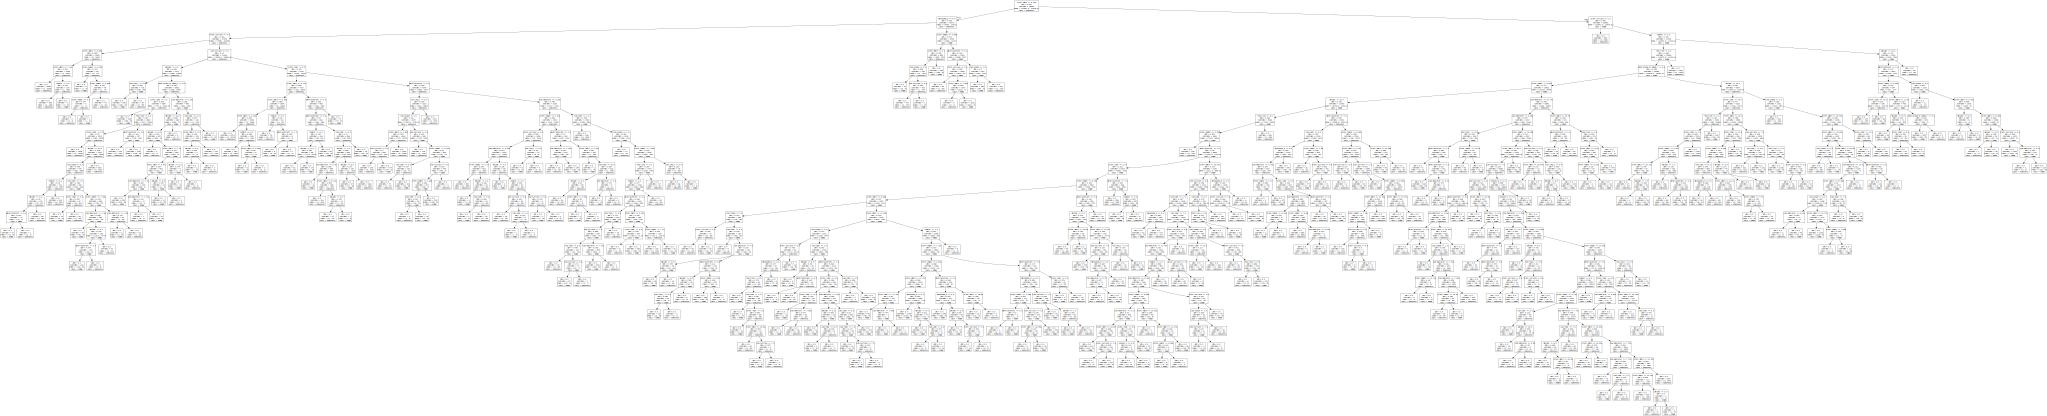

In [20]:
import graphviz
dot_data=export_graphviz(tree, out_file = None, feature_names =X.columns, class_names = ['edible', 'poisonous'])
graph = graphviz.Source(dot_data)
graph

### Random Forest

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=80, random_state=42) 
rf_classifier.fit(X_train, y_train)

y_test_pred = rf_classifier.predict(X_test)
y_train_pred = rf_classifier.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Training Accuracy: 1.0000
Testing Accuracy: 1.0000
[[5374    0]
 [   0 6840]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



### Logistic Regression 

In [22]:
import statsmodels.api as sm
logit_model = sm.Logit(y_train, sm.add_constant(X_train))  
result = logit_model.fit()

y_train_pred_prob = result.predict(sm.add_constant(X_train))  
y_train_pred = (y_train_pred_prob > 0.5).astype(int)  

train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred_prob = result.predict(sm.add_constant(X_test))  
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  

test_accuracy = accuracy_score(y_test, y_test_pred)
print("training:", train_accuracy)
print("testing:", test_accuracy)

Optimization terminated successfully.
         Current function value: 0.616923
         Iterations 6
training: 0.6503121481936343
testing: 0.6525298837399706


<Axes: >

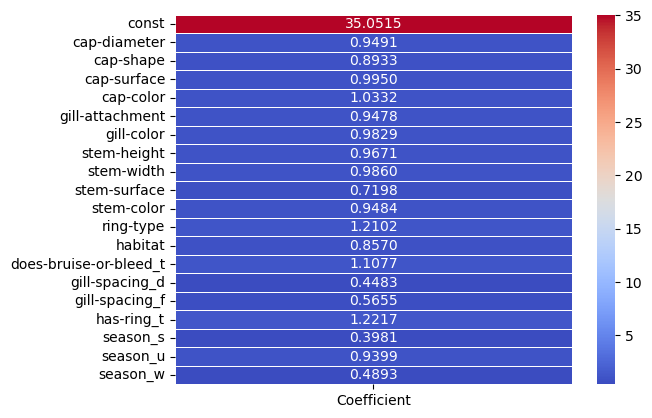

In [23]:
coefficients = np.exp(result.params)
coef_df = pd.DataFrame(coefficients, columns=["Coefficient"])
sns.heatmap(coef_df, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".4f")

If OR > 1 → Increases probability of class 1.
If OR < 1 → Decreases probability of class 1.

In [24]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                48855
Model:                          Logit   Df Residuals:                    48835
Method:                           MLE   Df Model:                           19
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.1025
Time:                        21:03:14   Log-Likelihood:                -30140.
converged:                       True   LL-Null:                       -33582.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.5568      0.069     51.188      0.000       3.421       3.693
cap-diameter              -0.0522      0.003    -15.284      0.000      -0.059      -0.046
cap-

Most Impactful Features (Absolute Coefficients):
1. Season (s)	-0.9210	Strongly decreases probability of class 1.
2. Gill Spacing (d)	-0.8024	Strongly decreases probability of class 1.
3. Season (w)	-0.7147	Strongly decreases probability of class 1.
4. Stem Surface	-0.3288	Significant negative impact.
5. Ring Type	0.1908	Positively affects classification.

### KNN

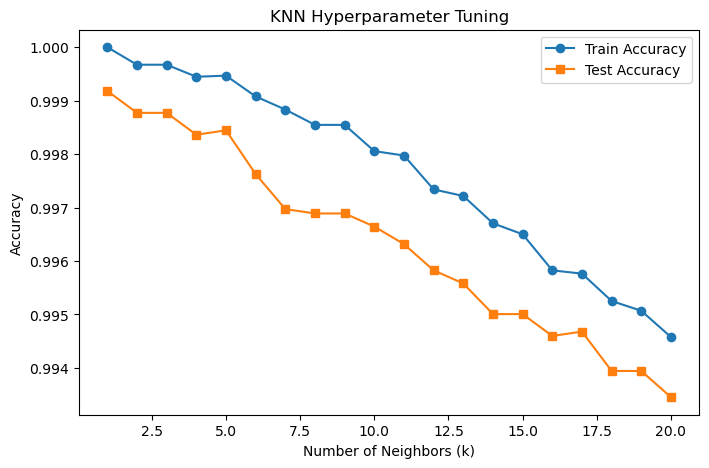

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, knn.predict(X_train)))
    test_scores.append(accuracy_score(y_test, knn.predict(X_test)))

# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_scores, label="Train Accuracy", marker="o")
plt.plot(k_values, test_scores, label="Test Accuracy", marker="s")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("KNN Hyperparameter Tuning")
plt.show()


In [26]:

knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Training Accuracy: 0.9995
Testing Accuracy: 0.9984
[[5367    7]
 [  12 6828]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



In [27]:
X_test.index

Index([11541, 35700, 55781, 29303, 46601, 44573,  4948, 33350,   431, 43050,
       ...
       24595, 50297, 42223, 60217,  7234, 28533, 13683, 14595, 50231, 17552],
      dtype='int64', length=12214)

In [29]:
sample_index = 35700
sample_data = X_test.loc[sample_index, :].values.reshape(1, -1)
distances, indices = knn.kneighbors(sample_data)
print("Nearest Neighbors' Indices:", indices)
print("Nearest Neighbors' Distances:", distances)

Nearest Neighbors' Indices: [[11803 41015 26947 46026 18966]]
Nearest Neighbors' Distances: [[0.37735925 0.56356011 0.58770741 0.64915329 0.78115299]]


/Users/kattygeng/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
